In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy
import math
import time
from scipy import interpolate
%matplotlib widget

In [65]:
df = pd.read_csv("./SVR Matches/Processed/FRC_20220410_180202_CASJ_Q81.csv")

In [66]:
cols = ["NT:/SmartDashboard/HoodManual/Hood Position", "NT:/SmartDashboard/HoodManual/Hood PID Goal", "NT:/SmartDashboard/HoodManual/Hood PID Error", "NT:/SmartDashboard/HoodManual/Hood PID Setpoint", "NT:/SmartDashboard/Shooter/Limelight Distance", "NT:/SmartDashboard/Shooter/Current Velocity"]
MAX = 10000000000000000000
MIN = -10000000000000000000
auton = True

In [67]:
dfs = []
for col in cols:
    dfs.append(df.loc[df['Name'] == col])

In [68]:
vals = [[]for i in range(len(dfs))]
times = [[] for i in range(len(dfs))]
for df1 in range(len(dfs)):
    for i in range(len(dfs[df1])):
#         if dfs[df1].iloc[i]["Name"] == "NT:/SmartDashboard/Shooter/Current Velocity":
#             curShooter = float(dfs[df1].iloc[i]["Value"])
#             curShooter
#         else:
        vals[df1].append(float(dfs[df1].iloc[i]["Value"]))
        times[df1].append(float(dfs[df1].iloc[i]["Timestamp"]))


In [69]:
llIndex = cols.index("NT:/SmartDashboard/Shooter/Limelight Distance")
if llIndex != -1:
    referencePoints = {}
    referencePoints[1.36] = 9.5
    referencePoints[1.54] = 13.0
    referencePoints[1.75] = 14.5
    referencePoints[1.91] = 18.0
    referencePoints[2.17] = 22.0
    referencePoints[2.4] = 23.0
    f = interpolate.interp1d(list(referencePoints.keys()), list(referencePoints.values()))
    estimatedPts = []

    for i in range(len(vals[llIndex])):
        if vals[llIndex][i] < list(referencePoints.keys())[0]:
            estimatedPts.append(list(referencePoints.values())[0])
        elif vals[llIndex][i] > list(referencePoints.keys())[-1]:
            estimatedPts.append(list(referencePoints.values())[-1])
        else:
            estimatedPts.append(f(vals[llIndex][i]))

In [70]:
autonBegin = None
first = None
autonRows = df.loc[df["Name"]=="DS:autonomous"]
enabledRows = df.loc[df["Name"]=="DS:enabled"]
for i in range(len(autonRows)):
    if autonRows.iloc[i]["Value"] == "true":
        first = i
        autonBegin = autonRows.iloc[i]["Timestamp"]
        break
for i in range(len(enabledRows)):
    if autonBegin != None and enabledRows.iloc[i]["Value"] == "true":
        autonBegin = enabledRows.iloc[i]["Timestamp"]
        break
autonEnd = None
for i in range(first, len(autonRows)):
    if autonRows.iloc[i]["Value"] == "false":
        autonEnd = autonRows.iloc[i]["Timestamp"]
        break

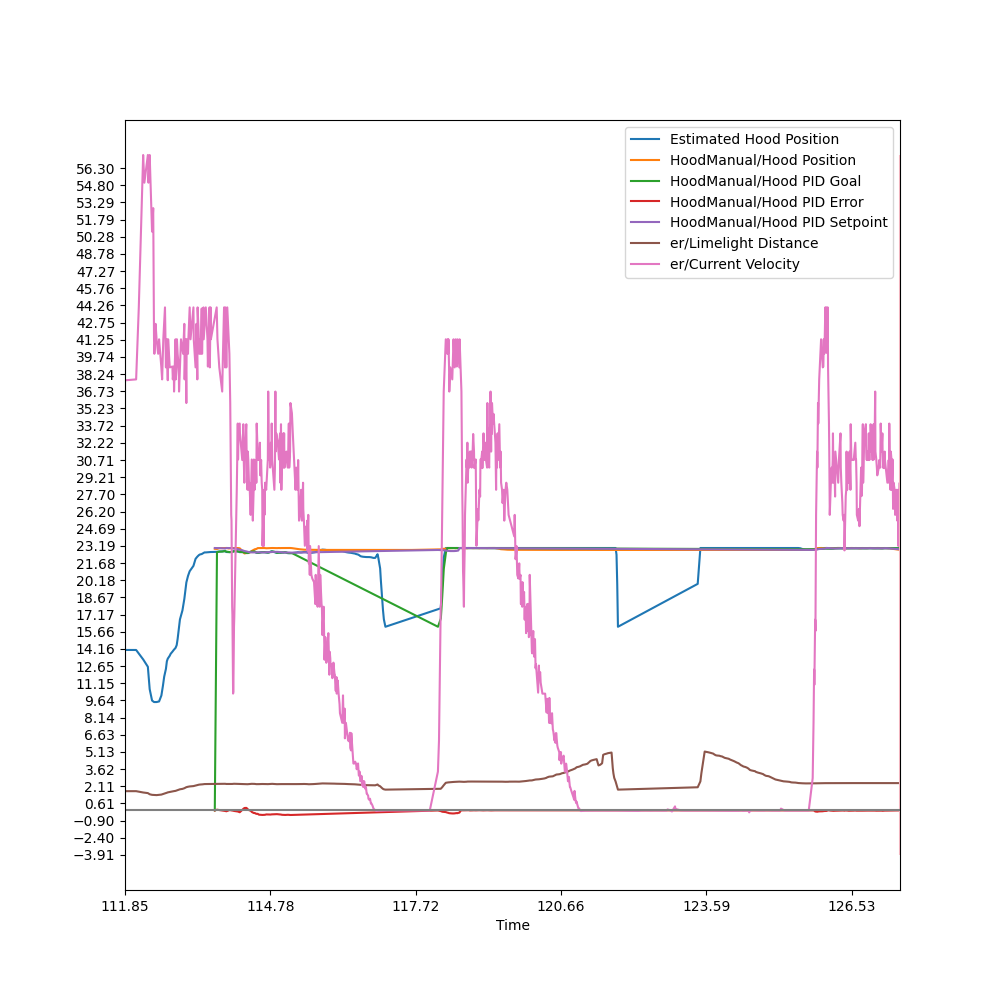

In [72]:
plt.figure(figsize=(10, 10))
if llIndex != -1:
    plt.plot(times[llIndex], estimatedPts, label = "Estimated Hood Position" )
for i in range(len(cols)):
    plt.plot(times[i], vals[i], label = cols[i].lstrip("NT:/SmartDashboard/") )
    
maxTime = MIN
minTime = MAX
maxVal = MIN
minVal = MAX
for i in range(len(cols)):
    if maxTime < max(times[i]):
        maxTime = max(times[i])
    if maxVal < max(vals[i]):
        maxVal = max(vals[i])
    if minVal > min(vals[i]):
        minVal = min(vals[i])
    if minTime > min(times[i]):
        minTime = min(times[i])

if auton:
    plt.xlim(autonBegin, autonEnd)
    plt.xticks(numpy.arange(autonBegin, autonEnd, (autonEnd+autonBegin)/len(times[0])*50))
else:
    plt.xticks(numpy.arange(autonBegin, maxTime, (maxTime+autonBegin)/len(times[0])*50))
    plt.xlim(autonBegin, maxTime)
    
if auton:
    plt.vlines(x=autonEnd, ymin = minVal, ymax = maxVal, color="pink")

plt.yticks(numpy.arange(minVal, maxVal, (maxVal-minVal)/len(vals[0])*100))
plt.xlabel("Time")

plt.axhline(0, color="gray")
plt.legend()
plt.show()